## How to reconstruct exact sampling coefficients

This how-to guide is intended to show users how they can retrieve exact sampling coefficients to be used in reconstructing the simulated expectation value of the original circuit.

In [1]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Sampler

from circuit_knitting_toolbox.circuit_cutting import (
    partition_problem,
    execute_experiments,
)

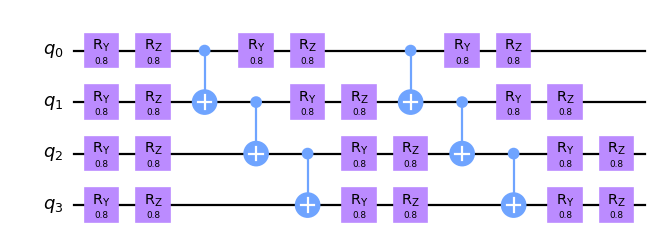

In [2]:
circuit = EfficientSU2(4, entanglement="linear", reps=2).decompose()
circuit.assign_parameters([0.8] * len(circuit.parameters), inplace=True)
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])
circuit.draw("mpl", scale=0.8)

Partition the circuit between qubits 1 and 2 by cutting 2 CNOT gates

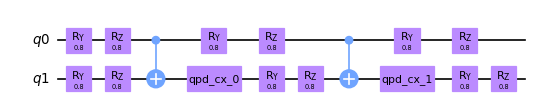

In [3]:
subcircuits, bases, subobservables = partition_problem(
    circuit=circuit, partition_labels="AABB", observables=observables
)
subcircuits["A"].draw("mpl", scale=0.6)

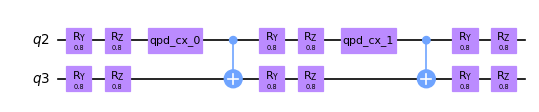

In [4]:
subcircuits["B"].draw("mpl", scale=0.6)

#### Demonstrate how to find the minimum number of samples needed to retrieve exact weights for 2 CNOT cuts

In order to retrieve exact coefficients and use them during reconstruction, the number of samples taken must be sufficient to cover the entire distribution. More specifically, if the smallest sample probability in the joint quasi-probability distribution is above 1 / `num_samples`, exact weights will be used.  Otherwise, the weights will be sampled, resulting in at most `num_samples` unique samples.

Here, we are cutting two CNOT gates. As shown below, the probability of any given mapping in a CNOT decomposition is 1/6, so the probability of any given mapping in the joint distribution combining the two cut CNOT gates is (1/6)^2. Therefore, we need to take at least 6^2 samples in order to retrieve the exact weights from `execute_experiments`.

In [5]:
from circuit_knitting_toolbox.circuit_cutting.qpd import QPDBasis
from qiskit.circuit.library.standard_gates import CXGate

qpd_basis_cx = QPDBasis.from_gate(CXGate())

num_cx_cuts = 2

print(f"Mapping probabilities for a CNOT decomposition: {qpd_basis_cx.probabilities}")
print(
    f"Number of samples needed to retrieve exact weights: {1 / min(qpd_basis_cx.probabilities)**num_cx_cuts}"
)

Mapping probabilities for a CNOT decomposition: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Number of samples needed to retrieve exact weights: 36.0


#### Observe the coefficient weights returned from `execute_experiments` are WeightType.EXACT

Above, we determined 36 samples would trigger the coefficients to be returned as exact. Here we set `num_samples` to exactly 36 to test this.

In [6]:
sampler = Sampler()

quasi_dists, coefficients = execute_experiments(
    circuits=subcircuits,
    subobservables=subobservables,
    num_samples=36,
    samplers=sampler,
)
coefficients[0:5]

[(0.25, <WeightType.EXACT: 1>),
 (0.25, <WeightType.EXACT: 1>),
 (0.25, <WeightType.EXACT: 1>),
 (-0.25, <WeightType.EXACT: 1>),
 (0.25, <WeightType.EXACT: 1>)]